<a href="https://colab.research.google.com/github/sushmit86/Data_science_experiments/blob/master/d2l/Chapter4_Kaggle_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/d2l-ai/d2l-en

  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-di7h3l10
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-di7h3l10
  Created wheel for d2l: filename=d2l-0.15.1-cp36-none-any.whl size=69687 sha256=b06624c3abb517971b874ded4b1317bcc2a043f6368af4904ddf16271a0a2057
  Stored in directory: /tmp/pip-ephem-wheel-cache-gr7xirs_/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l


In [3]:
import os
import requests
import zipfile
import tarfile
import hashlib
from google.colab import  drive
#drive.mount("/drive", force_remount=True)
#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

Mounted at /drive


In [4]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [5]:
def download_extract(name, folder=None):  #@save
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

In [6]:
from d2l import torch as d2l
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('Solarize_Light2')
%matplotlib inline

In [7]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [8]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [9]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


# Data Info

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# EDA

In [11]:
eda_data = train_data.copy()
eda_data['log_SalePrice'] = np.log(eda_data.SalePrice)
def plot_describe(feature):
  fig,axs = plt.subplots(1,2, figsize = (16,6))
  sns.histplot(feature ,ax = axs[0],label=feature.name)
  axs[0].legend(loc="upper right")
  sns.histplot(np.log(feature) ,ax = axs[1],label="log" + ' ' + feature.name)
  axs[1].legend(loc="upper right")
  fig.show()
  display(feature.describe())
  return True
def categoricalplot(feature_name):
  fig,axs = plt.subplots(2,1, figsize = (18,8))
  sns.violinplot(x= feature_name,y = 'SalePrice',data = eda_data, ax =axs[0], label = 'SalePrics Vs ' + feature_name)
  #axs[0].legend(loc="upper right")
  sns.violinplot(x= feature_name,y = 'log_SalePrice',data = eda_data, ax =axs[1], label = 'log SalePrics Vs ' + feature_name)
  #axs[1].legend(loc="upper right")
  fig.show()

def plot_feature_vs_sales(feature):
  feature = eda_data.LotFrontage
  fig,axs = plt.subplots(1,2, figsize = (16,6))
  sns.lineplot(x=feature, y=eda_data.SalePrice, ax= axs[0], label = feature.name)
  sns.lineplot(x=np.log(feature),  y=np.log(eda_data.SalePrice), ax = axs[1], label = 'log' +' ' + feature.name)
  fig.show()

## MSSubClass

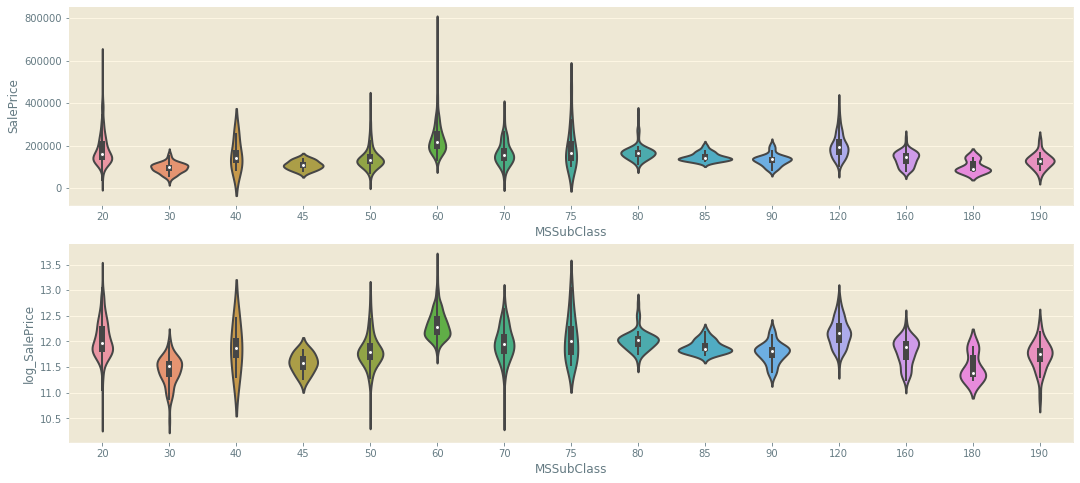

In [12]:
categoricalplot('MSSubClass')

## MSZoning

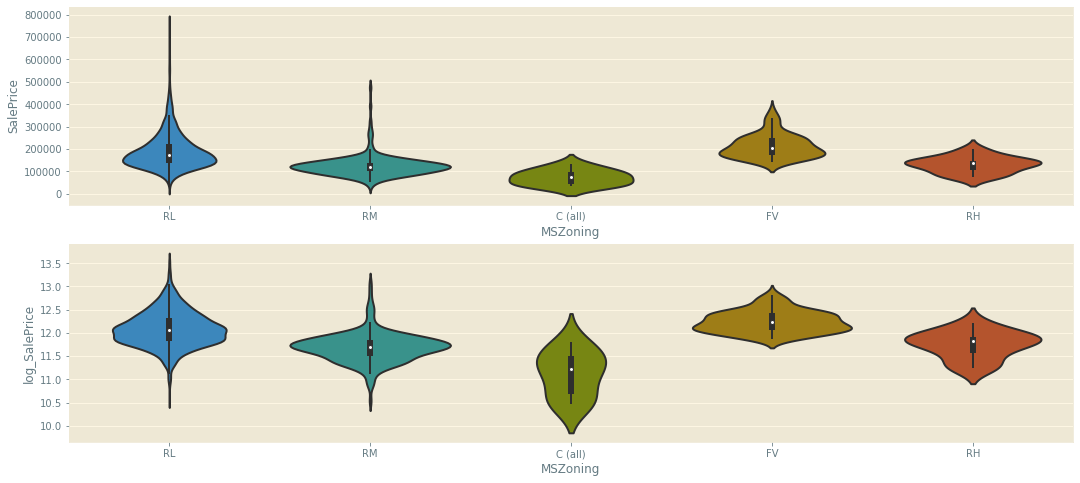

In [13]:
categoricalplot('MSZoning')

In [14]:
eda_data.MSZoning.value_counts(normalize = False)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

## LotFrontage

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

True

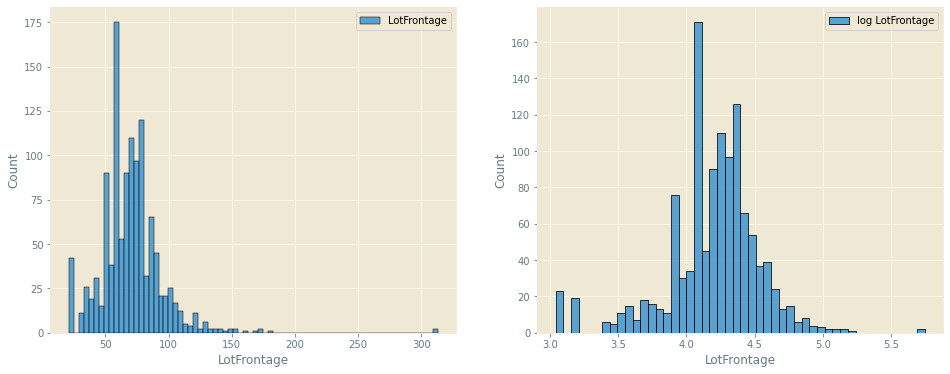

In [15]:
plot_describe(eda_data.LotFrontage)

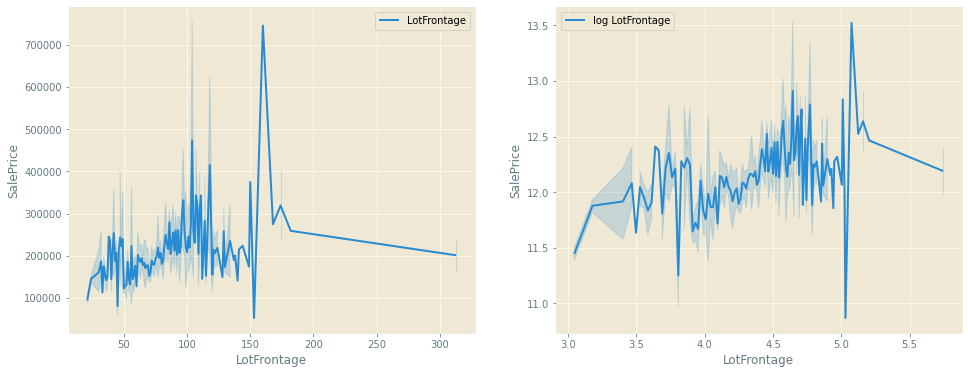

In [16]:
plot_feature_vs_sales(eda_data.LotFrontage)

## LotArea

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

True

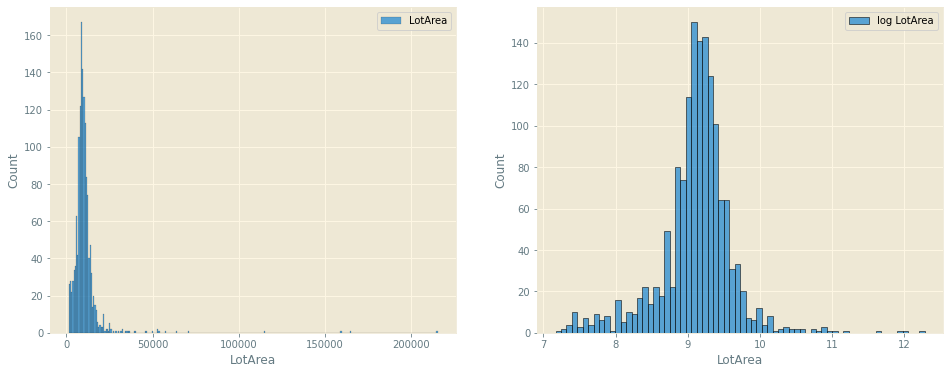

In [17]:
plot_describe(eda_data.LotArea)

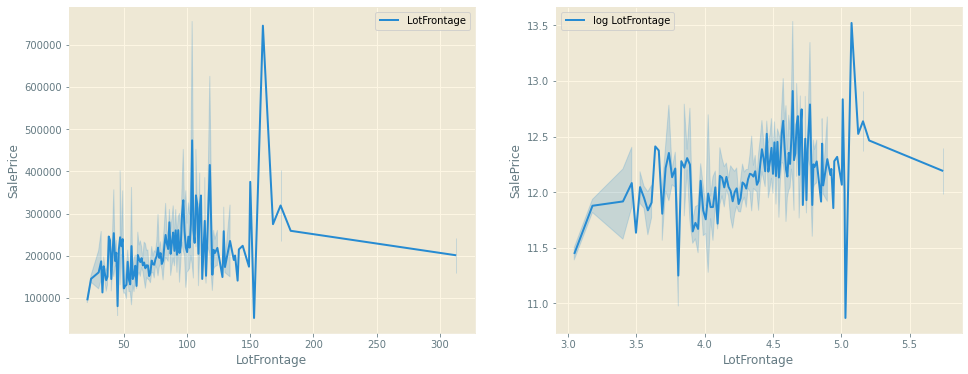

In [18]:
plot_feature_vs_sales(eda_data.LotArea)

## Street

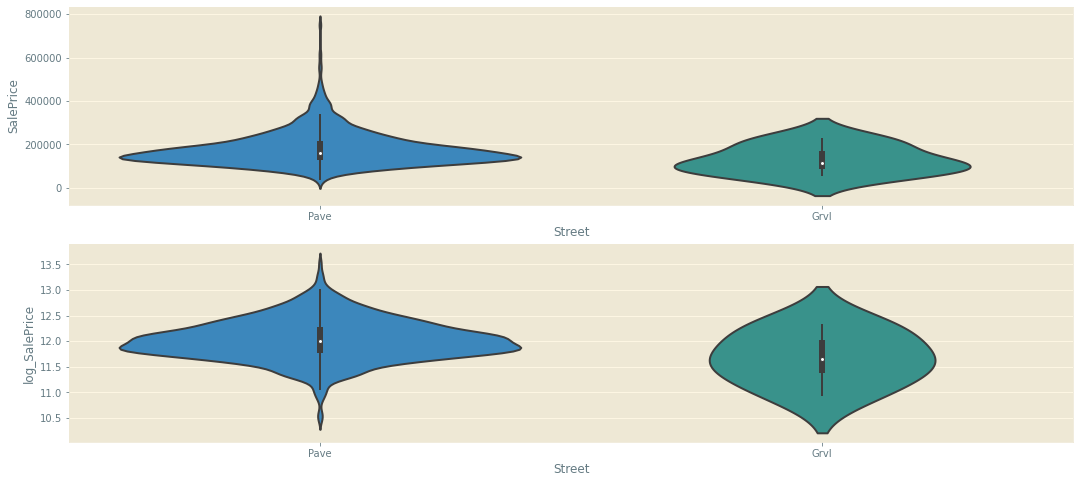

In [19]:
categoricalplot('Street')

In [20]:
441 * 730/1438

223.87343532684284